##### Shepard-Effekt

## Umsetzung in Python

Es wird die Shepard-Skala dargestellt, da die Frequenzveränderung in zeitlich diskreten Tonschritten passiert.

'shepard_tone.mid'

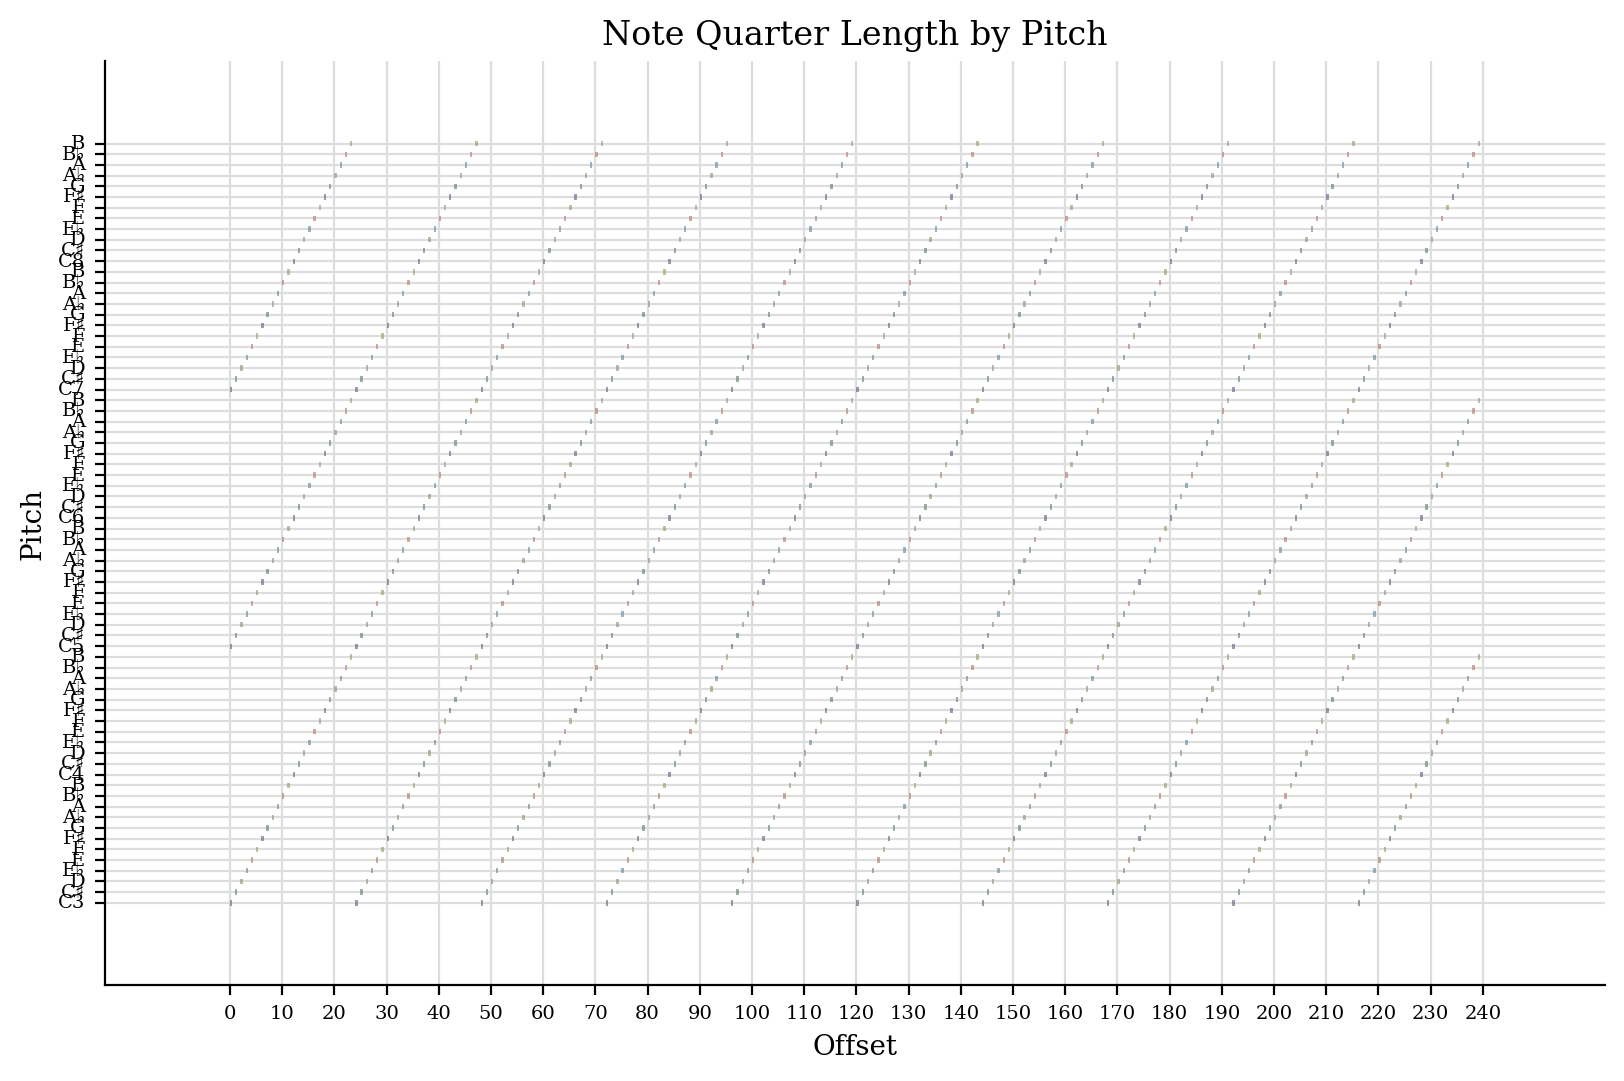

In [26]:
import sys
#!{sys.executable} -m pip install --upgrade music21

from music21 import stream, instrument, scale, dynamics, pitch, graph
from music21.note import Note


def create_shepard_tone_parts(
    stream,
    scale_name,
    loop_length,
    note_duration,
    accelerator,
    volume_start,
    pos_time_incr,
    output_instrument
):
    """Generate needed parts for shepard tone.

    Args:
        stream(music21.stream): Input stream
        scale_name (string): Name of major scale
        loop_length (int): How often the parts are repeated
        note_duration (int): Length of quarter notes
        accelerator (int): Factor, with which the volume is increased or decreased
        volume_start (int): Starting volume of the lower pitched track, that fades in
        pos_time_incr (float): Increment value with which the pos_time gets increased
        output_instrument (music21.instrument): Instrument object that will be used to create the sound
    Returns:
        list of stream parts
    """
    
    # Create Stream Parts
    part_high = stream.Part(id='High')
    part_constant = stream.Part(id='Constant')
    part_low = stream.Part(id='Low')
    
    # Insert Instruments
    part_high.insert(0, output_instrument)
    part_constant.insert(0, output_instrument)
    part_low.insert(0, output_instrument)
    
    # Create Scales
    # https://github.com/jsundram/music21/blob/master/music21/scale.py
    note_scale = scale.ChromaticScale(scale_name)
    
    # Starting time position of MIDI-Track
    pos_time = 0.0 

    # Declare the constant volume
    # (This volume will be also used, as the final volume of the "fading in" track.)
    # 26 equals the numbers of pitches, that one tracks contains.
    constant_volume = volume_start + (accelerator * 26)  
    
    for episode in range(loop_length):
        
        # Equals a volume level that is rather quiet but increases over time.
        # After one episode it will be equal $constant_volume
        increment_volume = volume_start 
        
        # Equals a volume level that is rather loud but decreases over time.
        # After one episode it will be equal $volume_start
        decrement_volume = constant_volume 
        
        for (pitch_high, pitch_constant, pitch_low) in zip(
            note_scale.getPitches('C7', 'B8', direction=scale.Direction.ASCENDING),
            note_scale.getPitches('C5', 'B6', direction=scale.Direction.ASCENDING),
            note_scale.getPitches('C3', 'B4', direction=scale.Direction.ASCENDING)
        ):
            # Create Notes
            note_low = Note(pitch_low, quarterLength=note_length)
            note_low.volume.velocity = increment_volume
            
            note_constant = Note(pitch_constant, quarterLength=note_length)
            note_constant.volume.velocity = 88
            
            note_high = Note(pitch_high, quarterLength=note_length)
            note_high.volume.velocity = decrement_volume
            
            # Insert Notes into the correct point of time
            part_high.insert(pos_time, note_high)
            part_constant.insert(pos_time, note_constant)
            part_low.insert(pos_time, note_low)
            
            # 
            pos_time += pos_time_incr
            
            # Increase/Decrease volumes
            increment_volume += accelerator
            decrement_volume -= accelerator
        
    return [part_low, part_constant, part_high]

# Constants
loop_length = 10
note_length = 0.5 # How long should the note be played for (time)

volume_start = 10 # Value between 0...127, see https://web.mit.edu/music21/doc/moduleReference/moduleVolume.html#music21.volume.Volume.velocity
accelerator = 3 # Choose smaller a value, we recommend a value between 1:10

pos_time_incr = 1.0 # Lower this value if you want to speed up the tracks, vice versa if you want to slow it down.

# Set output instrument
# For alternatives, see: https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html
output_instrument = instrument.Piano()


parts_list = create_shepard_tone_parts(
    stream,
    'C2',
    loop_length,
    note_length,
    accelerator,
    volume_start,
    pos_time_incr,
    output_instrument
)

shepard_stream = stream.Stream(parts_list)

# For further debugging information
#print(shepard_stream.show())

# Plot visual representation of the stream
p = graph.plot.HorizontalBarPitchSpaceOffset(shepard_stream)
p.run()

# Export results
p.write("stream_plot.png")
shepard_stream.write('midi', 'shepard_tone.mid')